# Method 2 - Best Ideas High Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] < qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

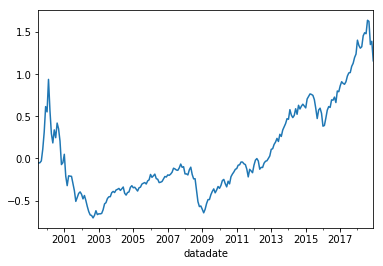

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.615851
2000-12-31   -0.411808
2001-12-31   -0.365259
2002-12-31   -0.446177
2003-12-31    0.783877
2004-12-31    0.135614
2005-12-31    0.102879
2006-12-31    0.045251
2007-12-31    0.156423
2008-12-31   -0.516790
2009-12-31    0.530788
2010-12-31    0.305227
2011-12-31   -0.045922
2012-12-31    0.239550
2013-12-31    0.429055
2014-12-31    0.102631
2015-12-31   -0.053606
2016-12-31    0.166675
2017-12-31    0.249165
2018-12-31   -0.035605
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     395.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.52e-101
Time:                        04:07:19   Log-Likelihood:                 514.88
No. Observations:                 234   AIC:                            -1020.
Df Residuals:                     229   BIC:                            -1002.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.002      0.046    5.78e-05       0.007
mktrf          1.0708      0.051     21.192      0.000       0.971       1.170
me             0.4429      0.059      7.536      0.000       0.327       0.559
ia            -0.7121      0.089     -7.972      0.000      -0.888      -0.536
roe           -0.5723      0.076     -7.484      0.000      -0.723      -0.422
==============================================================================
Omnibus:                       25.941   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.205
Skew:                          -0.104   Prob(JB):                     3.94e-28
Kurtosis:                       6.592   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     240.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.05e-80
Time:                        04:07:19   Log-Likelihood:                 514.88
No. Observations:                 234   AIC:                            -1020.
Df Residuals:                     229   BIC:                            -1002.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.743      0.081      -0.000       0.008
mktrf          1.0708      0.069     15.577      0.000       0.936       1.206
me             0.4429      0.118      3.749      0.000       0.211       0.674
ia            -0.7121      0.144     -4.939      0.000      -0.995      -0.430
roe           -0.5723      0.125     -4.589      0.000      -0.817      -0.328
==============================================================================
Omnibus:                       25.941   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.205
Skew:                          -0.104   Prob(JB):                     3.94e-28
Kurtosis:                       6.592   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     275.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.56e-86
Time:                        04:07:19   Log-Likelihood:                 514.88
No. Observations:                 234   AIC:                            -1020.
Df Residuals:                     229   BIC:                            -1002.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.780      0.075      -0.000       0.008
mktrf          1.0708      0.052     20.502      0.000       0.968       1.173
me             0.4429      0.114      3.874      0.000       0.219       0.667
ia            -0.7121      0.138     -5.157      0.000      -0.983      -0.441
roe           -0.5723      0.120     -4.755      0.000      -0.808      -0.336
==============================================================================
Omnibus:                       25.941   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.205
Skew:                          -0.104   Prob(JB):                     3.94e-28
Kurtosis:                       6.592   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     424.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.23e-113
Time:                        04:07:19   Log-Likelihood:                 546.03
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     228   BIC:                            -1059.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.612      0.010       0.001       0.008
mktrf          1.1038      0.044     24.851      0.000       1.016       1.191
smb            0.3813      0.059      6.505      0.000       0.266       0.497
hml           -0.2990      0.069     -4.327      0.000      -0.435      -0.163
rmw           -0.7441      0.078     -9.523      0.000      -0.898      -0.590
cma           -0.1440      0.099     -1.450      0.148      -0.340       0.052
==============================================================================
Omnibus:                       17.190   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.532
Skew:                          -0.330   Prob(JB):                     1.17e-08
Kurtosis:                       4.819   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     223.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.04e-85
Time:                        04:07:19   Log-Likelihood:                 546.03
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     228   BIC:                            -1059.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.746      0.006       0.001       0.007
mktrf          1.1038      0.053     20.810      0.000       1.000       1.208
smb            0.3813      0.049      7.715      0.000       0.284       0.478
hml           -0.2990      0.093     -3.212      0.001      -0.482      -0.117
rmw           -0.7441      0.084     -8.878      0.000      -0.908      -0.580
cma           -0.1440      0.134     -1.077      0.282      -0.406       0.118
==============================================================================
Omnibus:                       17.190   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.532
Skew:                          -0.330   Prob(JB):                     1.17e-08
Kurtosis:                       4.819   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     281.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.25e-95
Time:                        04:07:19   Log-Likelihood:                 546.03
No. Observations:                 234   AIC:                            -1080.
Df Residuals:                     228   BIC:                            -1059.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      3.099      0.002       0.002       0.007
mktrf          1.1038      0.054     20.437      0.000       0.998       1.210
smb            0.3813      0.044      8.682      0.000       0.295       0.467
hml           -0.2990      0.078     -3.833      0.000      -0.452      -0.146
rmw           -0.7441      0.076     -9.775      0.000      -0.893      -0.595
cma           -0.1440      0.127     -1.135      0.257      -0.393       0.105
==============================================================================
Omnibus:                       17.190   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.532
Skew:                          -0.330   Prob(JB):                     1.17e-08
Kurtosis:                       4.819   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     379.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.03e-99
Time:                        04:07:19   Log-Likelihood:                 510.56
No. Observations:                 234   AIC:                            -1011.
Df Residuals:                     229   BIC:                            -993.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.293      0.770      -0.003       0.004
mktrf          1.2733      0.047     26.868      0.000       1.180       1.367
smb            0.6444      0.059     10.894      0.000       0.528       0.761
hml           -0.5115      0.059     -8.705      0.000      -0.627      -0.396
umd           -0.0919      0.039     -2.384      0.018      -0.168      -0.016
==============================================================================
Omnibus:                       16.088   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.107
Skew:                          -0.135   Prob(JB):                     1.60e-10
Kurtosis:                       5.134   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     182.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.19e-70
Time:                        04:07:20   Log-Likelihood:                 510.56
No. Observations:                 234   AIC:                            -1011.
Df Residuals:                     229   BIC:                            -993.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.283      0.777      -0.003       0.004
mktrf          1.2733      0.069     18.425      0.000       1.138       1.409
smb            0.6444      0.101      6.357      0.000       0.446       0.843
hml           -0.5115      0.093     -5.504      0.000      -0.694      -0.329
umd           -0.0919      0.061     -1.503      0.133      -0.212       0.028
==============================================================================
Omnibus:                       16.088   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.107
Skew:                          -0.135   Prob(JB):                     1.60e-10
Kurtosis:                       5.134   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     148.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.40e-62
Time:                        04:07:20   Log-Likelihood:                 510.56
No. Observations:                 234   AIC:                            -1011.
Df Residuals:                     229   BIC:                            -993.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.314      0.753      -0.003       0.004
mktrf          1.2733      0.073     17.515      0.000       1.131       1.416
smb            0.6444      0.088      7.364      0.000       0.473       0.816
hml           -0.5115      0.092     -5.563      0.000      -0.692      -0.331
umd           -0.0919      0.068     -1.350      0.177      -0.225       0.042
==============================================================================
Omnibus:                       16.088   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.107
Skew:                          -0.135   Prob(JB):                     1.60e-10
Kurtosis:                       5.134   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     193.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.71e-50
Time:                        04:07:20   Log-Likelihood:                 236.53
No. Observations:                 120   AIC:                            -463.1
Df Residuals:                     115   BIC:                            -449.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      0.878      0.382      -0.004       0.009
mktrf          1.1211      0.089     12.632      0.000       0.945       1.297
me             0.5109      0.088      5.829      0.000       0.337       0.685
ia            -0.8055      0.137     -5.868      0.000      -1.077      -0.534
roe           -0.5195      0.121     -4.276      0.000      -0.760      -0.279
==============================================================================
Omnibus:                        7.932   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               15.747
Skew:                           0.040   Prob(JB):                     0.000381
Kurtosis:                       4.773   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     146.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.07e-44
Time:                        04:07:20   Log-Likelihood:                 236.53
No. Observations:                 120   AIC:                            -463.1
Df Residuals:                     115   BIC:                            -449.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.004      0.747      0.455      -0.005       0.010
mktrf          1.1211      0.120      9.337      0.000       0.886       1.356
me             0.5109      0.136      3.769      0.000       0.245       0.777
ia            -0.8055      0.194     -4.159      0.000      -1.185      -0.426
roe           -0.5195      0.194     -2.680      0.007      -0.899      -0.140
==============================================================================
Omnibus:                        7.932   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               15.747
Skew:                           0.040   Prob(JB):                     0.000381
Kurtosis:                       4.773   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     218.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-52
Time:                        04:07:20   Log-Likelihood:                 236.53
No. Observations:                 120   AIC:                            -463.1
Df Residuals:                     115   BIC:                            -449.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.004      0.781      0.435      -0.004       0.010
mktrf          1.1211      0.097     11.543      0.000       0.931       1.311
me             0.5109      0.135      3.780      0.000       0.246       0.776
ia            -0.8055      0.181     -4.455      0.000      -1.160      -0.451
roe           -0.5195      0.185     -2.808      0.005      -0.882      -0.157
==============================================================================
Omnibus:                        7.932   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.019   Jarque-Bera (JB):               15.747
Skew:                           0.040   Prob(JB):                     0.000381
Kurtosis:                       4.773   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     244.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.31e-59
Time:                        04:07:20   Log-Likelihood:                 261.63
No. Observations:                 120   AIC:                            -511.3
Df Residuals:                     114   BIC:                            -494.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.003      2.131      0.035       0.000       0.011
mktrf          1.1808      0.076     15.485      0.000       1.030       1.332
smb            0.4251      0.086      4.923      0.000       0.254       0.596
hml           -0.3812      0.106     -3.602      0.000      -0.591      -0.172
rmw           -0.6732      0.125     -5.394      0.000      -0.920      -0.426
cma           -0.1257      0.137     -0.919      0.360      -0.396       0.145
==============================================================================
Omnibus:                        9.555   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.717
Skew:                          -0.427   Prob(JB):                      0.00173
Kurtosis:                       4.346   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     237.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.43e-58
Time:                        04:07:20   Log-Likelihood:                 261.63
No. Observations:                 120   AIC:                            -511.3
Df Residuals:                     114   BIC:                            -494.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      2.411      0.016       0.001       0.011
mktrf          1.1808      0.084     14.017      0.000       1.016       1.346
smb            0.4251      0.058      7.336      0.000       0.312       0.539
hml           -0.3812      0.119     -3.213      0.001      -0.614      -0.149
rmw           -0.6732      0.118     -5.711      0.000      -0.904      -0.442
cma           -0.1257      0.176     -0.713      0.476      -0.471       0.220
==============================================================================
Omnibus:                        9.555   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.717
Skew:                          -0.427   Prob(JB):                      0.00173
Kurtosis:                       4.346   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     382.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.77e-69
Time:                        04:07:20   Log-Likelihood:                 261.63
No. Observations:                 120   AIC:                            -511.3
Df Residuals:                     114   BIC:                            -494.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.002      2.873      0.004       0.002       0.010
mktrf          1.1808      0.077     15.254      0.000       1.029       1.332
smb            0.4251      0.052      8.194      0.000       0.323       0.527
hml           -0.3812      0.095     -4.017      0.000      -0.567      -0.195
rmw           -0.6732      0.109     -6.164      0.000      -0.887      -0.459
cma           -0.1257      0.172     -0.731      0.465      -0.463       0.211
==============================================================================
Omnibus:                        9.555   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.717
Skew:                          -0.427   Prob(JB):                      0.00173
Kurtosis:                       4.346   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     234.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.42e-54
Time:                        04:07:20   Log-Likelihood:                 246.86
No. Observations:                 120   AIC:                            -483.7
Df Residuals:                     115   BIC:                            -469.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.631      0.529      -0.004       0.008
mktrf          1.4219      0.072     19.820      0.000       1.280       1.564
smb            0.6390      0.082      7.823      0.000       0.477       0.801
hml           -0.5850      0.082     -7.151      0.000      -0.747      -0.423
umd           -0.0282      0.050     -0.558      0.578      -0.128       0.072
==============================================================================
Omnibus:                       13.394   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.796
Skew:                          -0.511   Prob(JB):                     1.85e-05
Kurtosis:                       4.821   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     225.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.86e-53
Time:                        04:07:20   Log-Likelihood:                 246.86
No. Observations:                 120   AIC:                            -483.7
Df Residuals:                     115   BIC:                            -469.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.613      0.540      -0.004       0.008
mktrf          1.4219      0.081     17.590      0.000       1.263       1.580
smb            0.6390      0.108      5.915      0.000       0.427       0.851
hml           -0.5850      0.099     -5.912      0.000      -0.779      -0.391
umd           -0.0282      0.060     -0.470      0.638      -0.146       0.089
==============================================================================
Omnibus:                       13.394   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.796
Skew:                          -0.511   Prob(JB):                     1.85e-05
Kurtosis:                       4.821   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     306.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.40e-60
Time:                        04:07:20   Log-Likelihood:                 246.86
No. Observations:                 120   AIC:                            -483.7
Df Residuals:                     115   BIC:                            -469.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.003      0.713      0.476      -0.003       0.007
mktrf          1.4219      0.062     22.862      0.000       1.300       1.544
smb            0.6390      0.091      7.032      0.000       0.461       0.817
hml           -0.5850      0.079     -7.374      0.000      -0.741      -0.430
umd           -0.0282      0.058     -0.486      0.627      -0.142       0.085
==============================================================================
Omnibus:                       13.394   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.796
Skew:                          -0.511   Prob(JB):                     1.85e-05
Kurtosis:                       4.821   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     277.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.58e-56
Time:                        04:07:20   Log-Likelihood:                 321.82
No. Observations:                 114   AIC:                            -633.6
Df Residuals:                     109   BIC:                            -620.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      2.961      0.004       0.001       0.007
mktrf          1.0277      0.043     23.770      0.000       0.942       1.113
me             0.3047      0.067      4.565      0.000       0.172       0.437
ia            -0.3507      0.093     -3.787      0.000      -0.534      -0.167
roe           -0.4673      0.081     -5.743      0.000      -0.629      -0.306
==============================================================================
Omnibus:                        2.146   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.997
Skew:                          -0.323   Prob(JB):                        0.368
Kurtosis:                       2.937   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     521.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.67e-70
Time:                        04:07:20   Log-Likelihood:                 321.82
No. Observations:                 114   AIC:                            -633.6
Df Residuals:                     109   BIC:                            -620.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      4.964      0.000       0.003       0.006
mktrf          1.0277      0.036     28.896      0.000       0.958       1.097
me             0.3047      0.049      6.274      0.000       0.210       0.400
ia            -0.3507      0.112     -3.121      0.002      -0.571      -0.130
roe           -0.4673      0.079     -5.906      0.000      -0.622      -0.312
==============================================================================
Omnibus:                        2.146   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.997
Skew:                          -0.323   Prob(JB):                        0.368
Kurtosis:                       2.937   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     1074.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-86
Time:                        04:07:20   Log-Likelihood:                 321.82
No. Observations:                 114   AIC:                            -633.6
Df Residuals:                     109   BIC:                            -620.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      5.328      0.000       0.003       0.006
mktrf          1.0277      0.034     30.593      0.000       0.962       1.094
me             0.3047      0.047      6.449      0.000       0.212       0.397
ia            -0.3507      0.122     -2.879      0.004      -0.589      -0.112
roe           -0.4673      0.075     -6.251      0.000      -0.614      -0.321
==============================================================================
Omnibus:                        2.146   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.997
Skew:                          -0.323   Prob(JB):                        0.368
Kurtosis:                       2.937   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     164.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.90e-49
Time:                        04:07:20   Log-Likelihood:                 306.83
No. Observations:                 114   AIC:                            -601.7
Df Residuals:                     108   BIC:                            -585.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.609      0.110      -0.001       0.006
mktrf          1.0504      0.047     22.233      0.000       0.957       1.144
smb            0.3269      0.077      4.263      0.000       0.175       0.479
hml           -0.0617      0.098     -0.630      0.530      -0.256       0.132
rmw           -0.4295      0.120     -3.586      0.001      -0.667      -0.192
cma           -0.1496      0.152     -0.984      0.327      -0.451       0.152
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.255
Skew:                          -0.251   Prob(JB):                        0.534
Kurtosis:                       2.886   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     424.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.95e-69
Time:                        04:07:20   Log-Likelihood:                 306.83
No. Observations:                 114   AIC:                            -601.7
Df Residuals:                     108   BIC:                            -585.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.056      0.040       0.000       0.005
mktrf          1.0504      0.036     29.489      0.000       0.981       1.120
smb            0.3269      0.068      4.816      0.000       0.194       0.460
hml           -0.0617      0.097     -0.634      0.526      -0.252       0.129
rmw           -0.4295      0.138     -3.120      0.002      -0.699      -0.160
cma           -0.1496      0.180     -0.833      0.405      -0.502       0.203
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.255
Skew:                          -0.251   Prob(JB):                        0.534
Kurtosis:                       2.886   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     825.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.71e-84
Time:                        04:07:20   Log-Likelihood:                 306.83
No. Observations:                 114   AIC:                            -601.7
Df Residuals:                     108   BIC:                            -585.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.147      0.032       0.000       0.005
mktrf          1.0504      0.034     31.205      0.000       0.984       1.116
smb            0.3269      0.066      4.926      0.000       0.197       0.457
hml           -0.0617      0.088     -0.697      0.486      -0.235       0.112
rmw           -0.4295      0.126     -3.411      0.001      -0.676      -0.183
cma           -0.1496      0.201     -0.743      0.458      -0.544       0.245
==============================================================================
Omnibus:                        1.302   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.255
Skew:                          -0.251   Prob(JB):                        0.534
Kurtosis:                       2.886   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     191.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.62e-48
Time:                        04:07:20   Log-Likelihood:                 302.84
No. Observations:                 114   AIC:                            -595.7
Df Residuals:                     109   BIC:                            -582.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.286      0.201      -0.001       0.006
mktrf          1.0663      0.048     22.034      0.000       0.970       1.162
smb            0.4322      0.075      5.727      0.000       0.283       0.582
hml           -0.1228      0.078     -1.581      0.117      -0.277       0.031
umd           -0.1568      0.059     -2.675      0.009      -0.273      -0.041
==============================================================================
Omnibus:                        0.968   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                1.015
Skew:                          -0.116   Prob(JB):                        0.602
Kurtosis:                       2.600   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     292.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.45e-57
Time:                        04:07:20   Log-Likelihood:                 302.84
No. Observations:                 114   AIC:                            -595.7
Df Residuals:                     109   BIC:                            -582.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.966      0.049    6.61e-06       0.004
mktrf          1.0663      0.042     25.224      0.000       0.983       1.149
smb            0.4322      0.063      6.875      0.000       0.309       0.555
hml           -0.1228      0.109     -1.124      0.261      -0.337       0.091
umd           -0.1568      0.078     -2.002      0.045      -0.310      -0.003
==============================================================================
Omnibus:                        0.968   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                1.015
Skew:                          -0.116   Prob(JB):                        0.602
Kurtosis:                       2.600   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     490.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-68
Time:                        04:07:20   Log-Likelihood:                 302.84
No. Observations:                 114   AIC:                            -595.7
Df Residuals:                     109   BIC:                            -582.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.369      0.018       0.000       0.004
mktrf          1.0663      0.040     26.789      0.000       0.988       1.144
smb            0.4322      0.052      8.330      0.000       0.331       0.534
hml           -0.1228      0.104     -1.181      0.238      -0.327       0.081
umd           -0.1568      0.082     -1.913      0.056      -0.318       0.004
==============================================================================
Omnibus:                        0.968   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.616   Jarque-Bera (JB):                1.015
Skew:                          -0.116   Prob(JB):                        0.602
Kurtosis:                       2.600   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""